In [169]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

random forest models modified. changed criterion to absolute error

In [170]:
def add_t_minus(df, n):
    if n == 0:
        return df
    df_res = df.copy()
    for i in range(1,n+1):
        df_shifted = df.shift(i)
        diff = df - df_shifted.interpolate(method='spline', limit_direction='backward', order=1)
        #diff = diff.drop('weekofyear', axis=1)
        #diff = diff.drop('week_sin', axis=1)
        #diff = diff.drop('week_cos', axis=1)
        for cname in diff.columns:
            diff.rename(columns = {cname:cname+'_'+str(i)}, inplace = True)

        df_res = df_res.join(diff)
    return df_res

def sj_preprocess_data(features, labels=None, tminus=0):
    pruned = ['weekofyear', 'ndvi_nw', 'ndvi_se', 'reanalysis_dew_point_temp_k',
       'reanalysis_specific_humidity_g_per_kg']
    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)
    features['week_sin'] = np.sin(2 * np.pi * features['weekofyear']/53.0)
    features['week_cos'] = np.cos(2 * np.pi * features['weekofyear']/53.0)
    features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)

    pruned.remove('weekofyear')
    pruned += ['week_sin','week_cos']

    print(pruned)
    
    if labels is not None:
        #nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        nfeatures = add_t_minus(features[pruned], tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features[pruned], tminus)


def iq_preprocess_data(features, labels=None, tminus=0):
    pruned = ['weekofyear', 'ndvi_nw', 'ndvi_sw', 'reanalysis_air_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_min_temp_c', 'station_precip_mm']

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)
    features['week_sin'] = np.sin(2 * np.pi * features['weekofyear']/53.0)
    features['week_cos'] = np.cos(2 * np.pi * features['weekofyear']/53.0)
    features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)

    pruned.remove('weekofyear')
    pruned += ['week_sin','week_cos']

    print(pruned)
    
    if labels is not None:
        #nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        nfeatures = add_t_minus(features[pruned], tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features[pruned], tminus)



def get_data(features_path, labels_path=None, sj_tminus=0, iq_tminus=0):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = sj_preprocess_data(sj_features, sj_labels, sj_tminus)
        iq_f, iq_l = iq_preprocess_data(iq_features, iq_labels, iq_tminus)
        return sj_f, sj_l, iq_f, iq_l

    return sj_preprocess_data(sj_features, None, sj_tminus), iq_preprocess_data(iq_features, None, iq_tminus)


In [171]:
sj_tminus = 1
iq_tminus = 1
sj_X_train, sj_y_train, iq_X_train, iq_y_train = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv',
                                                        sj_tminus=sj_tminus,
                                                        iq_tminus=iq_tminus,
                                                        )

['ndvi_nw', 'ndvi_se', 'reanalysis_dew_point_temp_k', 'reanalysis_specific_humidity_g_per_kg', 'week_sin', 'week_cos']
['ndvi_nw', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_min_temp_c', 'station_precip_mm', 'week_sin', 'week_cos']


In [172]:
sj_X_train - sj_X_train.shift(6).interpolate(method='spline', limit_direction='backward', order=1)

,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,week_sin,week_cos,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1,week_sin_1,week_cos_1
week_start_date,,,,,,,,,,,,
1990-04-30,-0.045519,0.019491,-2.438880,-2.184941,0.858476,-0.467984,-0.044867,0.019342,-2.556953,-2.529083,0.870943,-0.469420
1990-05-07,-0.006898,-0.016632,-0.976745,-0.906553,0.789389,-0.564349,0.038336,-0.036267,1.530061,1.353654,-0.067011,-0.095860
1990-05-14,0.024064,-0.021787,0.431105,0.487549,0.709401,-0.651869,0.030678,-0.005297,1.475796,1.469389,-0.077918,-0.087017
1990-05-21,0.096334,0.048573,0.231813,0.230223,0.619636,-0.729317,0.071987,0.070217,-0.131325,-0.182020,-0.087703,-0.076946
1990-05-28,0.113637,0.072218,0.668234,0.685753,0.521352,-0.795607,0.017022,0.023504,0.504410,0.530857,-0.096227,-0.065790
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,0.023200,0.160271,-0.845714,-0.722857,0.261728,-0.645350,-0.004450,0.291486,-1.514286,-1.234286,-0.074491,-0.035485
2008-04-01,0.078233,-0.126686,0.101429,0.124286,0.183563,-0.671775,0.055033,-0.286957,0.947143,0.847143,-0.078165,-0.026426
2008-04-08,-0.068170,-0.073872,0.230000,0.217143,0.102822,-0.688771,-0.146403,0.052814,0.128571,0.092857,-0.080741,-0.016995


# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [173]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_train, sj_y_train, test_size=0.3, shuffle=False)


iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_train, iq_y_train, test_size=0.3, shuffle=False)

#remove everythin before 2002, it doesnt seem to have any value
iq_X_train = iq_X_train.loc['2002-01-01':]
iq_y_train = iq_y_train.loc['2002-01-01':]


In [174]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ndvi_nw,655.0,0.096682,0.078717,-0.130950,0.050250,0.090200,0.134000,0.437100
ndvi_se,655.0,0.181044,0.054837,0.036000,0.146207,0.178579,0.212529,0.393129
reanalysis_dew_point_temp_k,655.0,295.067408,1.566198,289.642857,293.840714,295.447143,296.355714,297.467143
reanalysis_specific_humidity_g_per_kg,655.0,16.508540,1.547369,11.715714,15.237143,16.837143,17.805714,19.044286
week_sin,655.0,-0.016955,0.713937,-0.999561,-0.737833,-0.059241,0.696551,0.999561
week_cos,655.0,-0.036136,0.700163,-0.998244,-0.717507,-0.088796,0.674983,1.000000
ndvi_nw_1,655.0,-0.000284,0.085765,-0.362975,-0.045833,-0.000170,0.050225,0.327467
ndvi_se_1,655.0,0.000150,0.069418,-0.215257,-0.047606,-0.000003,0.044925,0.265691
reanalysis_dew_point_temp_k_1,655.0,0.001723,0.832599,-3.727143,-0.382857,0.010000,0.367143,3.590000
reanalysis_specific_humidity_g_per_kg_1,655.0,0.001488,0.790592,-3.575714,-0.394286,0.015714,0.372143,3.224286


In [175]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ndvi_nw,286.0,0.232114,0.075149,0.072986,0.174711,0.224271,0.284818,0.428771
ndvi_sw,286.0,0.260263,0.081016,0.064743,0.205636,0.258582,0.315911,0.493443
reanalysis_air_temp_k,286.0,297.842963,1.097544,294.635714,297.162500,297.807857,298.459286,301.175714
reanalysis_dew_point_temp_k,286.0,295.519940,1.404300,290.088571,294.573571,295.975714,296.575357,297.852857
reanalysis_precip_amt_kg_per_m2,286.0,54.558408,49.941984,0.100000,23.397500,42.925000,66.245000,362.030000
reanalysis_specific_humidity_g_per_kg,286.0,17.121352,1.426131,12.111429,16.079286,17.544286,18.212500,19.731429
reanalysis_tdtr_k,286.0,9.164627,2.410604,4.185714,7.371429,8.992857,10.942857,16.028571
station_avg_temp_c,286.0,27.592878,0.917537,21.400000,27.206250,27.650000,28.225000,30.800000
station_diur_temp_rng_c,286.0,10.279301,1.511783,5.200000,9.283978,10.166667,11.161828,15.800000
station_min_temp_c,286.0,21.431248,1.300726,16.800000,20.800000,21.700000,22.400000,24.200000


In [176]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

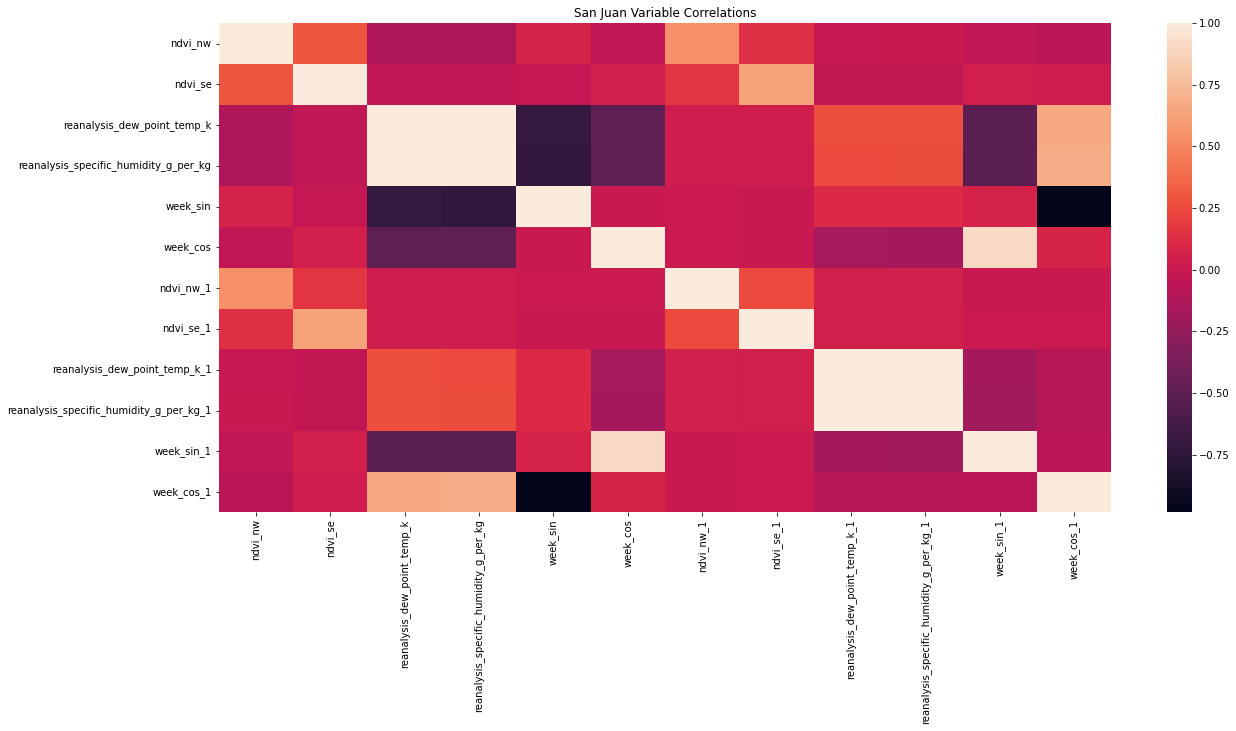

In [177]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [178]:
'''sj_rf = RandomForestRegressor(  n_estimators = 100, 
                                min_samples_leaf=25, 
                                criterion='absolute_error',
                                max_depth = 4)'''

sj_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=5,
                                criterion='squared_error',
                                )                               
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

15.88622260842622
23.234111976257015


In [179]:
sj_rf.feature_importances_

array([0.26697973, 0.18320247, 0.07566251, 0.05537384, 0.0670501 ,
       0.03481243, 0.06267921, 0.02434485, 0.01316449, 0.02051653,
       0.02069257, 0.17552128])

<AxesSubplot:ylabel='cols'>

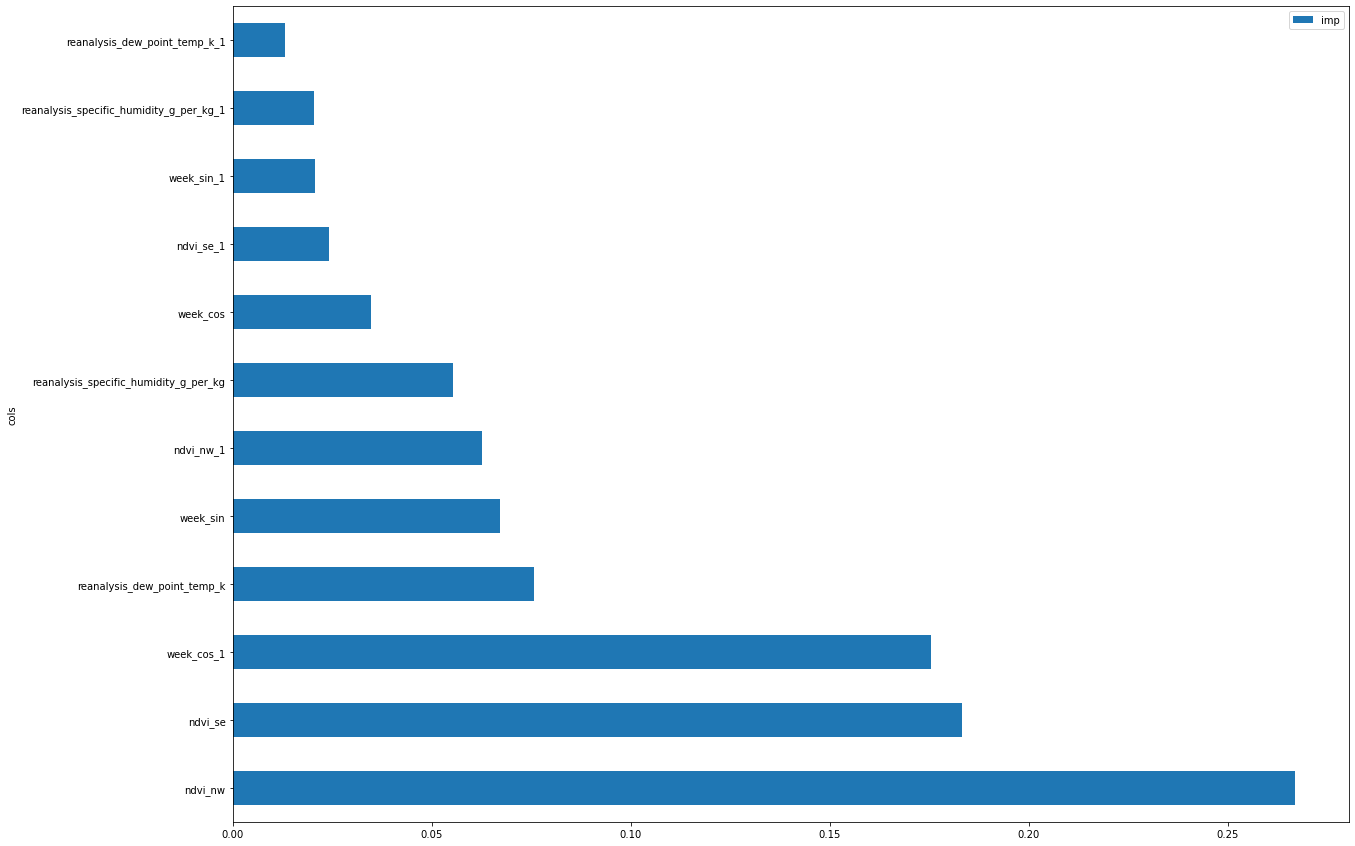

In [180]:
plt.rcParams["figure.figsize"] = (20,15)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [181]:
iq_rf =  RandomForestRegressor( n_estimators = 100, 
                                min_samples_leaf=5, 
                                criterion='squared_error',
                                )

'''iq_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=25,
                                criterion='absolute_error',)  '''
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

3.9331744667927913
6.988840130985925


In [182]:
iq_rf.feature_importances_

array([0.03984797, 0.02239468, 0.02588613, 0.0204612 , 0.03498084,
       0.04629194, 0.02789565, 0.02702179, 0.0322438 , 0.03534949,
       0.01608269, 0.03349258, 0.11287181, 0.03509459, 0.03689947,
       0.02208095, 0.01524768, 0.03140143, 0.01420127, 0.17309132,
       0.0166235 , 0.02588497, 0.02080179, 0.03590713, 0.06831595,
       0.02962938])

<AxesSubplot:ylabel='cols'>

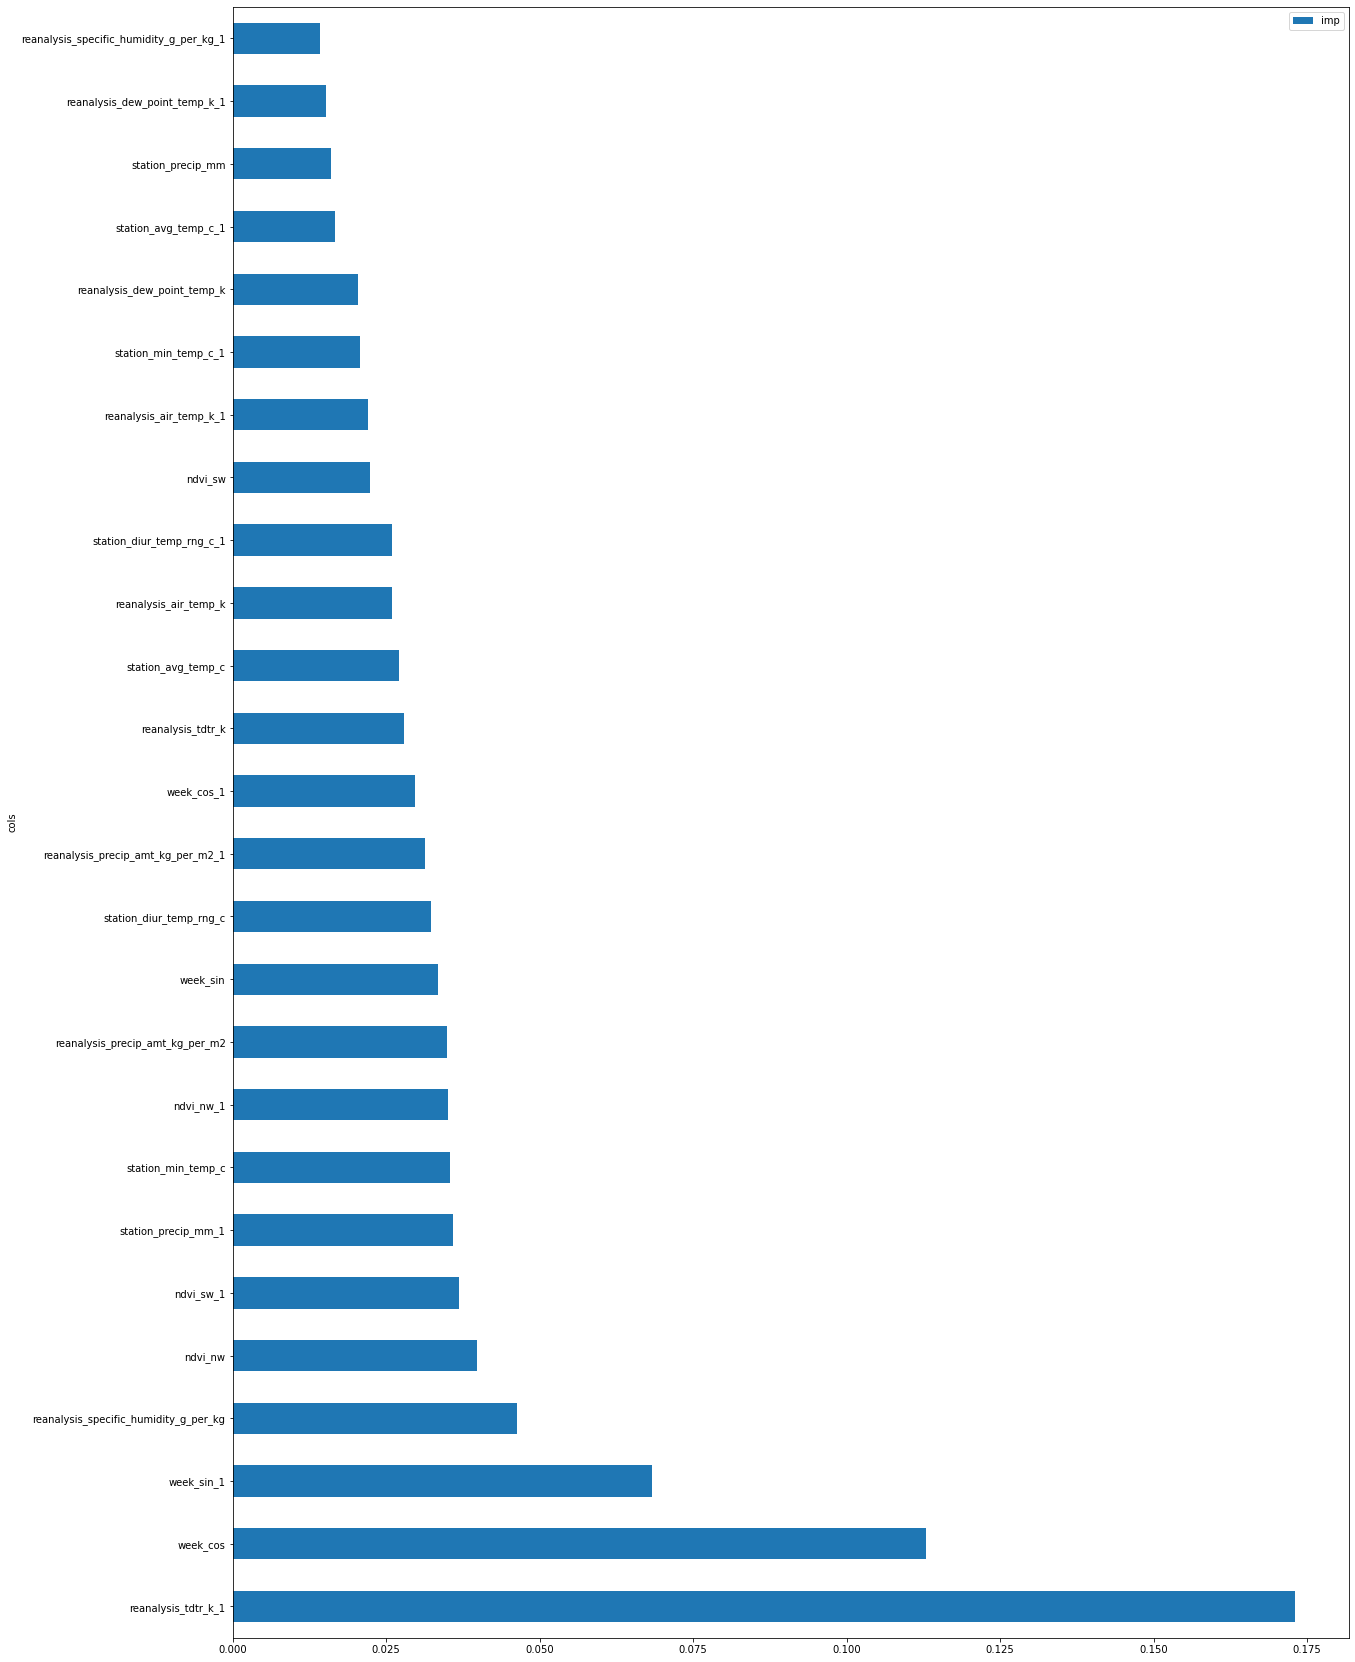

In [183]:
plt.rcParams["figure.figsize"] = (20,30)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

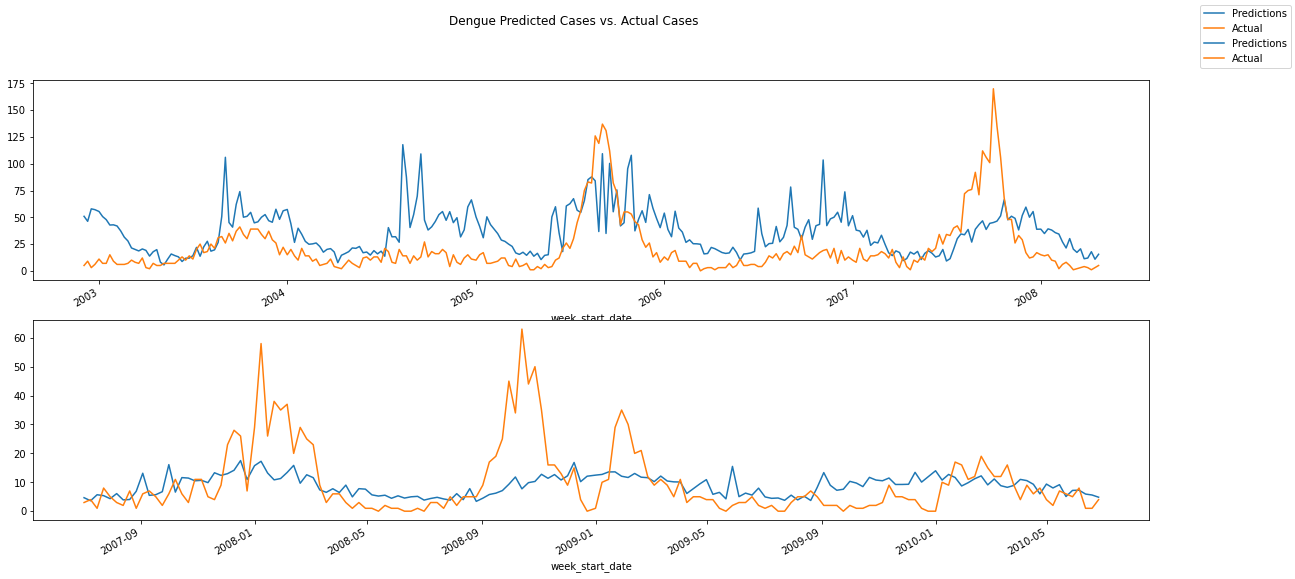

In [184]:
plt.rcParams["figure.figsize"] = (20,9)
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [185]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [186]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv',
                                    sj_tminus=sj_tminus,
                                    iq_tminus=iq_tminus,
                                    ) 

['ndvi_nw', 'ndvi_se', 'reanalysis_dew_point_temp_k', 'reanalysis_specific_humidity_g_per_kg', 'week_sin', 'week_cos']
['ndvi_nw', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_min_temp_c', 'station_precip_mm', 'week_sin', 'week_cos']


In [187]:
sj_X_valid

,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,week_sin,week_cos,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1,week_sin_1,week_cos_1
week_start_date,,,,,,,,,,,,
2008-04-29,-0.018900,0.102729,294.527143,15.918571,0.845596,-0.533823,-0.080356,-0.080643,-0.936836,-0.937541,0.931447,-0.356843
2008-05-06,-0.012400,0.082043,294.395714,15.791429,0.776524,-0.630088,0.006500,-0.020686,-0.131429,-0.127143,-0.069072,-0.096264
2008-05-13,0.061357,0.151083,295.308571,16.674286,0.696551,-0.717507,0.073757,0.069040,0.912857,0.882857,-0.079973,-0.087419
2008-05-20,-0.019867,0.124329,294.402857,15.775714,0.606800,-0.794854,-0.081223,-0.026755,-0.905714,-0.898571,-0.089751,-0.077347
2008-05-27,0.039833,0.062267,294.760000,16.137143,0.508531,-0.861044,0.059700,-0.062062,0.357143,0.361429,-0.098269,-0.066189
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,-0.016183,0.156343,294.675714,15.985714,0.999561,0.029633,-0.022408,0.048829,3.688571,3.280000,0.010521,-0.118013
2013-04-02,-0.077833,0.204171,294.628571,15.881429,0.996050,-0.088796,-0.061650,0.047828,-0.047143,-0.104286,-0.003511,-0.118429
2013-04-09,-0.008200,0.192700,294.948571,16.212857,0.978556,-0.205979,0.069633,-0.011471,0.320000,0.331429,-0.017493,-0.117183


In [188]:
iq_X_valid

,ndvi_nw,ndvi_sw,reanalysis_air_temp_k,reanalysis_dew_point_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_min_temp_c,...,reanalysis_dew_point_temp_k_1,reanalysis_precip_amt_kg_per_m2_1,reanalysis_specific_humidity_g_per_kg_1,reanalysis_tdtr_k_1,station_avg_temp_c_1,station_diur_temp_rng_c_1,station_min_temp_c_1,station_precip_mm_1,week_sin_1,week_cos_1
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,0.142500,0.150214,297.648571,296.118571,34.11,17.654286,9.428571,27.440,10.760,21.5,...,1.809212,-24.711818,1.814733,-0.709312,-0.186390,0.921957,2.20405,-2.145238,0.379112,-0.947587
2010-07-09,0.272267,0.320914,298.224286,294.831429,9.10,16.320000,10.157143,27.025,9.625,21.2,...,-1.287143,-25.010000,-1.334286,0.728571,-0.415000,-1.135000,-0.30000,-2.300000,-0.118481,0.000000
2010-07-16,0.366457,0.255514,297.955714,296.417143,61.09,18.030000,9.557143,26.950,10.350,21.6,...,1.585714,51.990000,1.710000,-0.600000,-0.075000,0.725000,0.40000,13.700000,-0.117650,0.014013
2010-07-23,0.063214,0.081957,295.715714,293.638571,19.60,15.394286,7.828571,26.900,9.700,14.2,...,-2.778571,-41.490000,-2.635714,-1.728571,-0.050000,-0.650000,-7.40000,-17.800000,-0.115166,0.027830
2010-07-30,0.327683,0.267914,298.502857,293.892857,18.93,15.468571,11.771429,27.050,11.850,16.9,...,0.254286,-0.670000,0.074286,3.942857,0.150000,2.150000,2.70000,-1.800000,-0.111067,0.041255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,0.380029,0.383186,297.774286,295.638571,67.60,17.185714,10.100000,27.400,9.050,21.8,...,-0.211429,-56.600000,-0.197143,3.400000,0.766667,0.150000,0.00000,-64.300000,-0.098269,-0.066189
2013-06-04,0.296343,0.350357,297.167143,295.845714,45.70,17.448571,9.657143,27.520,10.720,21.4,...,0.207143,-21.900000,0.262857,-0.442857,0.120000,1.670000,-0.40000,35.000000,-0.105408,-0.054102
2013-06-11,0.251029,0.249771,295.831429,294.894286,45.22,16.410000,7.385714,27.200,10.075,21.6,...,-0.951429,-0.480000,-1.038571,-2.271429,-0.320000,-0.645000,0.20000,25.200000,-0.111067,-0.041255


In [189]:
b = sj_rf.predict(sj_X_valid).astype(int)
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

In [190]:
sj_predictions, iq_predictions

(array([ 26,  19,  16,  24,  16,  21,  16,  18,  11,  16,   9,  15,  37,
         32,  47,  39,  23,  74, 105,  79,  46,  52,  47,  65,  71,  87,
         88,  52,  44,  48,  48,  48,  40,  35,  35,  41,  39,  36,  38,
         49,  27,  27,  26,  18,  19,  20,  13,  12,  15,  16,  12,  16,
         13,  15,  16,  16,  18,  24,  10,  15,  13,  10,  17,  24,  37,
         30,  21,  24,  27,  37,  63,  35,  44,  51,  57,  98,  60,  38,
         39,  67,  45,  50,  50,  50,  54,  55,  52,  60,  56,  54,  49,
         55,  38,  22,  35,  32,  32,  29,  14,  11,  17,  14,   9,  12,
         19,  15,  22,  15,  22,  56,  61,  59,  58,  62,  62,  62,  64,
         72,  76, 103, 117,  77, 122,  91,  94,  36,  48,  65,  85,  45,
         61,  57,  50,  45,  42,  50,  37,  47,  36,  32,  35,  56,  55,
         39,  31,  22,  33,  30,  23,  20,  16,  13,  17,  17,  16,   6,
         12,  19,  22,  19,  15,  27,  20,  57,  65,  62,  60,  66,  29,
         69,  45,  91,  57, 112,  93,  33,  73,  47

In [191]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 23.234111976257015
iq 6.988840130985925


sj 17.274501779359433
iq 7.246260500628908

In [192]:
sj_X_test

,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,week_sin,week_cos,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1,week_sin_1,week_cos_1
week_start_date,,,,,,,,,,,,
2002-12-03,-0.120933,0.279086,295.205714,16.578571,-0.456629,0.889657,-0.083683,0.001757,-0.887143,-0.931429,0.102018,6.025141e-02
2002-12-10,-0.072300,0.199300,294.978571,16.327143,-0.348202,0.937420,0.048633,-0.079786,-0.227143,-0.251429,0.108428,4.776257e-02
2002-12-17,-0.128950,0.185414,294.577143,15.918571,-0.234886,0.972023,-0.056650,-0.013886,-0.401429,-0.408571,0.113316,3.460325e-02
2002-12-24,-0.252800,0.243433,294.805714,16.160000,-0.118273,0.992981,-0.123850,0.058019,0.228571,0.241429,0.116613,2.095818e-02
2003-01-01,-0.045250,0.230457,294.381429,15.845714,0.118273,0.992981,0.207550,-0.012976,-0.424286,-0.314286,0.236546,-1.110223e-16
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,-0.039900,0.310471,292.095714,13.644286,0.999561,0.029633,-0.064350,0.208843,-0.110000,-0.092857,0.010521,-1.180132e-01
2008-04-01,-0.016833,0.119371,293.235714,14.662857,0.996050,-0.088796,0.023067,-0.191100,1.140000,1.018571,-0.003511,-1.184292e-01
2008-04-08,-0.052750,0.137757,292.732857,14.184286,0.978556,-0.205979,-0.035917,0.018386,-0.502857,-0.478571,-0.017493,-1.171827e-01


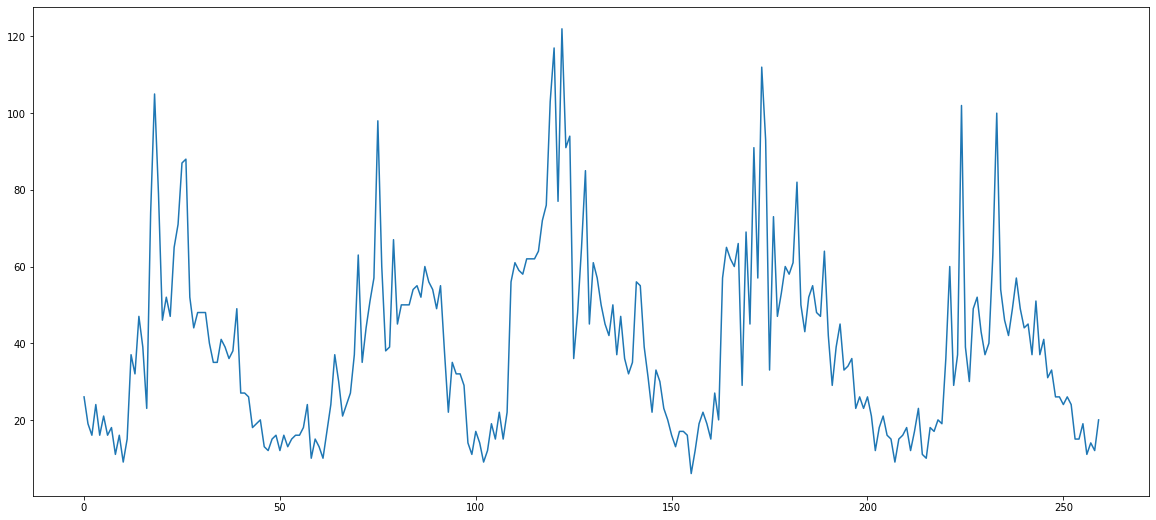

In [193]:
plt.plot(sj_predictions)

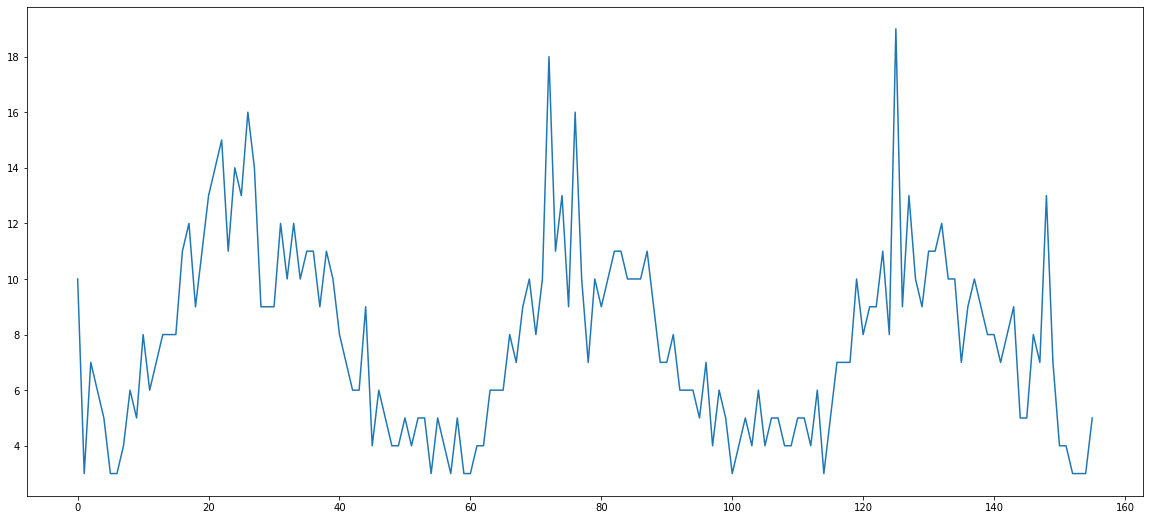

In [194]:
plt.plot(iq_predictions)